In [40]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout , Input , Flatten, concatenate , Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback

from matplotlib import pyplot as plt

In [2]:
# Загрузка тренировочного и тестового набора данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# Определение числа меток
num_labels = len(np.unique(y_train))

In [4]:
# Конвертация меток в формат hot-encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [5]:
# Нормализация данных

image_size = x_train.shape[1]

x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
x_test = np.reshape(x_test,[-1, image_size, image_size, 1])

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [6]:
# Определение конфигурации нейронной сети

# Размер входного изображения
input_shape = (image_size, image_size, 1)

# Размер пакета
batch_size = 32

# Размер ядра свёртки
kernel_size = 3

# Коэффициент отключения случайных нейронов
dropout = 0.4

# Число фильтров
n_filters = 32

In [81]:
# Кастомный свёрточный слой
class TfConv2D(tf.keras.layers.Layer):
  # Конструктор класса
  def __init__(self, kernel=(3,3), channels_count=1, strides=(2,2), padding='SAME', acivate='relu'):
    super().__init__()
    self.kernel = kernel
    self.channels_count = channels_count
    self.strides = strides
    self.padding = padding
    self.acivate = acivate
    self.fl_init = False

  # Делаем экземпляры класса вызываемыми
  def __call__(self,x):
    if not self.fl_init:
      self.w = tf.random.truncated_normal((*self.kernel, x.shape[-1], self.channels_count), stddev=0.1, dtype=tf.float32)
      self.b = tf.zeros([self.channels_count], dtype=tf.float32)

      # Преобразуем тензор в переменную, чтобы использовать в градиентном спуске
      self.w = tf.Variable(self.w)
      self.b = tf.Variable(self.b)

      self.fl_init = True

      y = tf.nn.conv2d(x, self.w, strides=(1, *self.strides, 1), padding=self.padding) + self.b

      # Определяем функцию активации и делегируем вычисления ей
      if self.acivate == "relu":
        return tf.nn.relu(y)
      elif self.acivate == "softmax":
        return tf.nn.softmax(y)

      return y

In [113]:
# Левая ветвь сети Y-DAG

filters = n_filters

# Определение входного слоя для левой ветви
left_inputs = Input(shape=input_shape)

# Инициализация переменной x
x = left_inputs

# Создание свёрточного слоя с числом фильтров 32
x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
# Отключение определённого числа случайных нейронов на случайных слоях
x = Dropout(dropout)(x)
# Слой для уменьшшения выборки входного слоя
x = MaxPooling2D()(x)

# Создание свёрточного слоя с числом фильтров 64
x = Conv2D(filters=(2 * filters), kernel_size=kernel_size, padding='same', activation='relu')(x)
x = Dropout(dropout)(x)
#x = TfConv2D(kernel=(kernel_size, kernel_size), channels_count=(2 * filters), acivate='relu')(x)
x = MaxPooling2D()(x)

# Создание свёрточного слоя с числом фильтров 128
x = Conv2D(filters=(4 * filters), kernel_size=kernel_size, padding='same', activation='relu')(x)
x = Dropout(dropout)(x)
x = MaxPooling2D()(x)

In [114]:
# Правая ветвь сети Y-DAG

filters = n_filters

# Определение входного слоя для правой ветви
right_inputs = Input(shape=input_shape)

y = right_inputs

# Создание свёрточного слоя с числом фильтров 32
y = Conv2D(filters = filters,kernel_size = kernel_size,padding = 'same',
           activation = 'relu',dilation_rate =2)(y)
# Отключение определённого числа случайных нейронов на случайных слоях
y = Dropout(dropout)(y)
# Слой для уменьшшения выборки входного слоя
y = MaxPooling2D()(y)

# Создание свёрточного слоя с числом фильтров 64
y = Conv2D(filters = (2 * filters),kernel_size = kernel_size,padding = 'same',
           activation = 'relu',dilation_rate =2)(y)
y = Dropout(dropout)(y)
#y = TfConv2D(kernel=(kernel_size, kernel_size), channels_count=(2 * filters), acivate='relu')(y)
y = MaxPooling2D()(y)

# Создание свёрточного слоя с числом фильтров 128
y = Conv2D(filters = (4 * filters),kernel_size = kernel_size,padding = 'same',
           activation = 'relu',dilation_rate =2)(y)
y = Dropout(dropout)(y)
y = MaxPooling2D()(y)


In [115]:
# Объединение ветвей нейронной сети
merge_xy = concatenate([x, y])

In [116]:
# Добавление новых слоёв

# Слой сжатия многомерных тензоров в одно измерение
merge_xy = Flatten()(merge_xy)
merge_xy = Dropout(dropout)(merge_xy)

# Выходной слой
outputs = Dense(num_labels , activation = 'softmax')(merge_xy)

In [117]:
# Сборка модели нейронной сети

model = Model(inputs=[left_inputs, right_inputs], outputs=outputs)

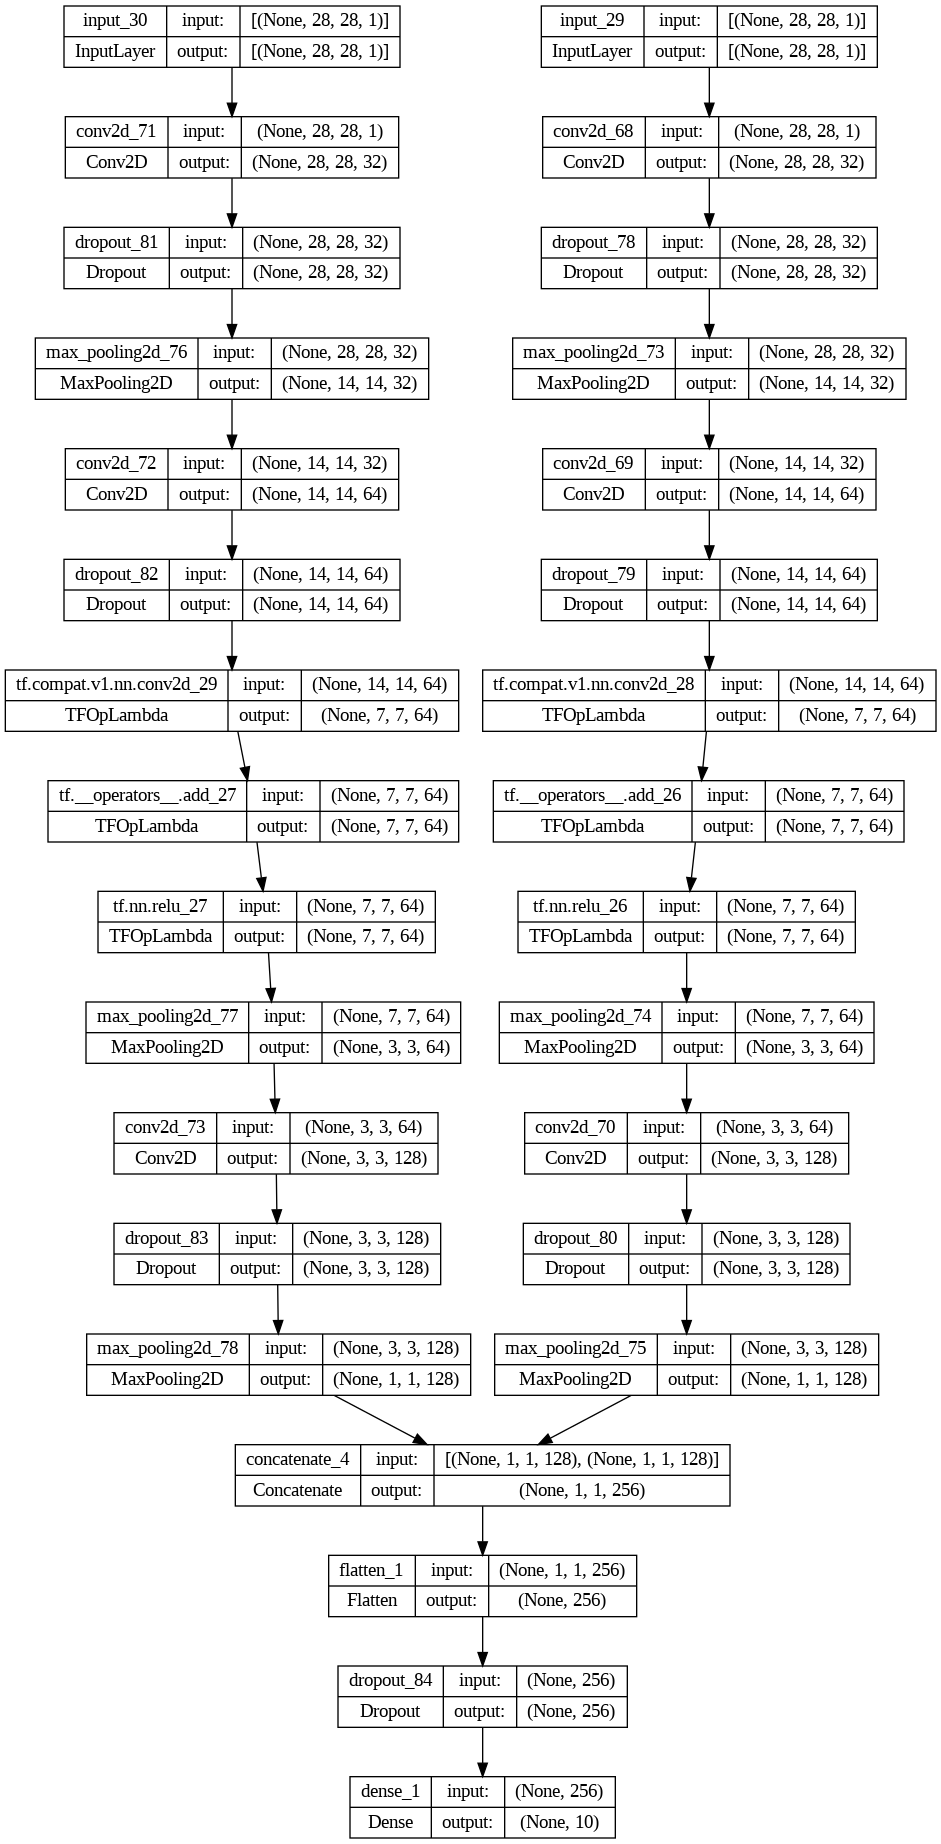

In [100]:
# Формирование рисунка с архитектурой Y-DAG нейронной сети
plot_model(model, to_file='cnn-Y-network2.png', show_shapes=True)

In [101]:
# Проверка модели

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_29 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_71 (Conv2D)          (None, 28, 28, 32)           320       ['input_30[0][0]']            
                                                                                                  
 conv2d_68 (Conv2D)          (None, 28, 28, 32)           320       ['input_29[0][0]']            
                                                                                            

In [118]:
# Компиляция модели
model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

In [52]:
# Определение кастомной функции потерь
class CustomLoss(tf.keras.losses.Loss):
  def __init__(self, alpha=1.0, beta=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta

  def call(self, y_true, y_pred):
      # Средний квадрат ошибки
      return tf.reduce_mean(tf.square(self.alpha * y_true - self.beta * y_pred))

In [58]:
# Создание кастомного класса метрики
class CategoricalTruePositives(tf.keras.metrics.Metric):
    def __init__(self, name="my_metric"):
        super().__init__(name=name)
        self.true_positives = self.add_weight(name="acc", initializer="zeros")
        self.count = tf.Variable(0.0)

    # Обработка обновления переменных состояния
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        y_true = tf.reshape(tf.argmax(y_true, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")

        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)

        values = tf.cast(values, "float32")

        self.true_positives.assign_add(tf.reduce_mean(values))
        self.count.assign_add(1.0)

    # Метод для вычисления метрик на основе переменных состояния
    def result(self):
        return self.true_positives / self.count

    # Сброс переменных состояния
    def reset_states(self):
        self.true_positives.assign(0.0)
        self.count.assign(0.0)

In [59]:
# Компиляция модели
model.compile(loss=CustomLoss(0.5, 2.0),
                 optimizer='adam',
                 metrics=['accuracy', CategoricalTruePositives()])

In [45]:
# Реализация кастомного класса Callback
class LossPrintingCallback(Callback):
    # Вызов функции "завершение обучение на тренировочном пакете ..."
    def on_train_batch_end(self, batch, logs=None):
        print(
            " - Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])
        )

    # Вызов функции "завершение обучение на тестовом пакете ..."
    def on_test_batch_end(self, batch, logs=None):
        print(
            " - Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])
        )

In [119]:
# Обучение модели
model.fit([x_train, x_train],
             y_train,
             validation_data=([x_test, x_test], y_test),
             epochs=1,
             batch_size=batch_size)

1875/1875 [==============================] - 263s 139ms/step - loss: 0.1754 - accuracy: 0.9440 - val_loss: 0.1093 - val_accuracy: 0.9888


In [120]:
model.save("save_pb")

In [111]:
# Оценка работы модели
score = model.evaluate([x_test, x_test],
                          y_test,
                          batch_size=batch_size,
                          verbose=2)

313/313 - 9s - loss: 0.0432 - accuracy: 0.9889 - 9s/epoch - 27ms/step


In [105]:
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))


Test accuracy: 98.9%


In [121]:
# Сохранение архитектуры модели в формате JSON
model_json = model.to_json()

# Открытие файла JSON для записи
with open('model_architecture.json', 'w') as json_file:
    # Запись данных модели в файл JSON
    json_file.write(model_json)

In [110]:
model.save("save1")

AssertionError: Tried to export a function which references an 'untracked' resource. TensorFlow objects (e.g. tf.Variable) captured by functions must be 'tracked' by assigning them to an attribute of a tracked object or assigned to an attribute of the main object directly. See the information below:
	Function name = b'__inference_signature_wrapper_205978'
	Captured Tensor = <ResourceHandle(name="Variable/340", device="/job:localhost/replica:0/task:0/device:CPU:0", container="Anonymous", type="tensorflow::Var", dtype and shapes : "[ DType enum: 1, Shape: [3,3,64,64] ]")>
	Trackable referencing this tensor = <tf.Variable 'Variable:0' shape=(3, 3, 64, 64) dtype=float32>
	Internal Tensor = Tensor("205956:0", shape=(), dtype=resource)

In [108]:
def save_as_pb(self, directory, filename):

        if not os.path.exists(directory):
            os.makedirs(directory)

        # Save check point for graph frozen later
        ckpt_filepath = self.save(directory=directory, filename=filename)
        pbtxt_filename = filename + '.pbtxt'
        pbtxt_filepath = os.path.join(directory, pbtxt_filename)
        pb_filepath = os.path.join(directory, filename + '.pb')
        # This will only save the graph but the variables will not be saved.
        # You have to freeze your model first.
        tf.train.write_graph(graph_or_graph_def=self.sess.graph_def, logdir=directory, name=pbtxt_filename, as_text=True)

        # Freeze graph
        # Method 1
        freeze_graph.freeze_graph(input_graph=pbtxt_filepath, input_saver='', input_binary=False, input_checkpoint=ckpt_filepath, output_node_names='cnn/output', restore_op_name='save/restore_all', filename_tensor_name='save/Const:0', output_graph=pb_filepath, clear_devices=True, initializer_nodes='')

        return pb_filepath